# Data Management Package for the novel data delivery system, ServiceX, and its application to an ATLAS Run-2 Physics Analysis Workflow

### KyungEon Choi (UT Austin) 
### IRIS-HEP Topical Meeting | Nov 16, 2022

<br>
<br>
<br>

<img src="img/logo_servicex.png" width="100" height="100"  style="float:left" alt="ServiceX">

# ServiceX

<font size="3">
    A service to <b><span style="color:red;">quickly</span></b> access a "fraction" of large data on the grid 

<img src="img/ServiceX_diagram_1.pdf" height="140"  style="float:center" alt="ServiceX-1">


If an analyzer wants to see a distribution of a variable (or column or branch) of large data on the grid, one needs to submit a grid job or download all files. Instead, ServiceX delivers a column.

<br>
<br>
<br>
<br>

<font size="3">
    ServiceX is deployed in a Kubernetes cluster* and usually co-located with the data center to allow a wide network bandwidth.
</font>

<font size="2" style="float:right">*Container orchestration system</font>

<br>

<img src="img/ServiceX_diagram_2.pdf" height="140"  style="float:center" alt="ServiceX-1">

<br>

<font size="3">
    It spawns the so-called <b><span style="color:blue">Transformer</span></b> pods to read columns and filter events from each file in parallel. Transformer pods are also scaled automatically using Kubernetes auto-scaling feature. Outputs from each transformer are written to object store and then delivered to a destination as soon as it becomes available.
</font>
<img src="img/ServiceX_diagram_3.pdf" height="140"  style="float:center" alt="ServiceX-1">

<br>

<font size="3">
    Transformers are separated by the input data format. Currently transformers for two types of data format are maintained: 
    <ul style="line-height:1.6;">
        <li><b>Uproot transformer for flat ROOT ntuple (e.g. CMS nanoAOD)</b></li>
        <li><b>xAOD transformer for ATLAS xAOD data</b></li>
    </ul>
    Other types of transformers are also under development, including transformer for non-LHC HEP experiment.
</font>

<br>
<br>
<br>
<br>

<font size="3">
    <b><span style="color:blue">FuncADL</span></b> (Functional Analysis Description Language) is the query language that the two transformers understand to filter events and select columns. Details on the grammar and capabilities of FuncADL can be found from Mason's talk at PyHEP 2021.

<a href="https://indico.cern.ch/event/1019958/timetable/#31-funcadl-functional-analysis" target="_blank">
    <img src="img/funcadl.png" height="140"  style="float:center" alt="ServiceX-1">
</a>

The basic operators of FuncADL will be shown in this notebook: <code>Select()</code> to select columns and <code>Where()</code> to apply cuts.

<b><span style="color:blue">ROOT TCut syntax</span></b> is also supported to provide a more familiar experience:
- Supported expressions
  - Arithmetic operators: `+, -, *, /`
  - Logical operators: `!, &&, ||`
  - Relational and comparison operators: `==, !=, >, <, >=, <=`
  - Ternary operator: `(A?B:C)` - has to be enclosed in parentheses
  - Mathematical function: `sqrt`
- Limitations
    - Compatible with input data format of ROOT flat ntuple
    - Cuts can be applied to scalar type branches (crashes if a datatype of TTree branch is `std::vector`)


<br>
<br>
<br>
<br>

<font size="3">

The following <b><span style="color:blue">ServiceX endpoints</span></b> are  currently available for users to make data delivery requests.

| Type | Collaboration | Input data format | Location | Endpoint |
| :----: |:----: | :-----------------: | :--------: | :--------: |
| stand-alone | ATLAS | ROOT flat ntuple | UC Analysis Facility | https://uproot-atlas.servicex.af.uchicago.edu/ |
| stand-alone | ATLAS |xAOD | UC Analysis Facility | https://xaod.servicex.af.uchicago.edu/ |
| coffea-casa | CMS | ROOT flat ntuple | UNL | https://coffea.casa/ |
| coffea-casa | - | ROOT flat ntuple | UNL | https://coffea-opendata.casa |

- Type
    - `stand-alone`: Secured by own authentication system. An endpoint is accessible from anywhere with an access token.
    - `coffea-casa`: Integrated into a coffea-casa facility for CMS. Secured by CERN authentication system of coffea-casa facility and an ServiceX endpoint is not exposed to outside.
    
- Collaboration
    - Access to the experimental data
- Input data format
    - Dedicate endpoint for different types of input data format (or transformer)
- Location
    - ATLAS endpoints at University of Chicago Analysis Facility (UC AF)
    - CMS endpoints at University of Nebraska-Lincoln (UNL)


<br>
<br>
<br>
<br>

<font size="3">

<b><span style="color:blue">Access to a stand-alone ServiceX endpoint</span></b> requires a yaml file containing access information.

- A yaml file can have multiple endpoints
- Optionally other information (such as `cache_path`) can be placed
- For stand-alone endpoints, a config file can be downloaded from the webpage
- The config file can be called `servicex.yaml`, `servicex.yml`, or `.servicex`. The files are searched in that order, and all present are used.
- Searches in the current working directory, and above, and home directory (`$HOME` on Linux and Mac, and profile directory on Windows)

```
api_endpoints:
  - name: <your-endpoint-name>
    endpoint: <your-endpoint>
    token: <api-token>
    type: uproot
```

<br>
<br>
<br>
<br>

<font size="3">
    
<b><span style="color:blue">Local data cache</span></b> 

- ServiceX queries and data are stored in a local temporary directory by default
- The same query on the same dataset pulls the data from the local cache
- The cache is unbound: it will continuously fill up
- Cache path can (or need to) be changed in the configuration file

```
cache_path: <cache-path>
api_endpoints:
  - name: <your-endpoint-name>
    endpoint: <your-endpoint>
    token: <api-token>
    type: uproot
```

<br>
<br>
<br>
<br>

# ServiceX DataBinder


<font size="3">
    
<b><span style="color:blue">ServiceX DataBinder</span></b> is a Python library for <b><span style="color:red">"easy"</span></b> manipulations of ServiceX delivery requests and delivered data using a single configuration file.

<b>All you need to prepare are `servicex.yaml` and `servicex-databinder` to make use of ServiceX.</b>

In [ ]:
# %%writefile servicex.yaml
# api_endpoints:
#   - name: opendata_uproot_river
#     endpoint: https://atlasopendata.servicex.ssl-hep.org/
#     type: uproot

In [ ]:
# !pip install servicex-databinder

In [1]:
import servicex_databinder

In [2]:
servicex_databinder.__version__

'0.2.14'

In [3]:
from servicex_databinder import DataBinder


<font size="3">

Here is an example workflow with ServiceX DataBinder once you have your `servicex.yaml` file in place and installed `servicex-databinder`:

<img src="img/ServiceX_workflow_PyHEP.pdf" width=900 />

1. A user write a configuration for ServiceX DataBinder
1. Make ServiceX delivery requests from Jupyter notebook
1. ServiceX backend looks for input datasets and retrieves an input file list
1. A relevant code is generated based on the input data format, query in func-adl, and so on
1. Transformer pods (workers) are generated to process each file (10 pods at first and scale up if necessary)
1. Outputs are written to object store inside the Kubernetes cluster
1. Download outputs to the local cache directory asynchronously
1. Copy files to the final destination

Step 1 and 2 are done by a user.

<br>
<br>
<br>
<br>

<font size="4">
    
<b><span style="color:blue"> Use-case 1. </span></b> An analyzer simply wants to see the electron pT distribution of large dataset on the grid


<font size="3">   
Let's write a configuration file.
<br>
    
In `General` block:
- `ServiceXBackendName` is the endpoint name in your ServiceX access file (e.g. `servicex.yaml`)
- `OutputDirectory` is the target output directory
- `OutputFormat` is the format of ServiceX delivered files. Either `parquet` or `root` supported for Uproot
    
In `Sample` block follows:
- `Name` is the name of sample.
- `XRootDFiles` is the input files. These 50 files are CMS OpenData converted to flat ROOT ntuple and amount to about 10GB.
- `Tree` is the name of ROOT TTree that I want to read.
- `FuncADL` is the query that I want to pass to the transformers.


In [4]:
%%writefile config_example_1.yml
General:
  ServiceXBackendName: uproot_uc_af
  OutputDirectory: ServiceXData_1
  OutputFormat: parquet

Sample:
  - Name: ttbar
    XRootDFiles: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/020D0AF1-4BC2-E511-BDFC-0026B95ADB18.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/02837459-03C2-E511-8EA2-002590A887AC.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0400D1B1-4CC2-E511-AD14-AC853DA06A1A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0634456A-08C2-E511-A0C1-001E6739722E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5A5364-03C2-E511-9352-00259048AE00.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5C7429-0CC2-E511-BC6B-002590D9D8B8.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0AE230FC-4BC2-E511-B35C-000F530E4644.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0C5BB11A-E2C1-E511-8C02-002590A831B6.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/10D0AF2E-33C2-E511-BCE5-001E67398683.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/14C8A87C-DCC1-E511-BE67-0CC47A0AD704.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/14F4047E-0CC2-E511-B1CE-002590A3C970.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/16467C82-D8C1-E511-9546-001E67E71417.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/167A53AB-08C2-E511-A58B-001E67397F2B.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/18897870-17C2-E511-9DC5-E41D2D08DCA0.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/18CCDFE4-02C2-E511-B0FA-002590A37114.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/20A0646D-D8C1-E511-9587-001E67396A09.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2235F83F-DBC1-E511-A83F-001E673986B5.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/22761DF1-E1C1-E511-8F86-003048CB8584.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/244D8186-D8C1-E511-B684-001E67E71BF5.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/26CAB9BA-CEC1-E511-8B0B-001E67398E49.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2A18493A-04C2-E511-935C-002590D9D8C2.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2C7F8762-0CC2-E511-9F77-001E673981C4.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2CA9FB72-17C2-E511-A3E3-0025907DCA7E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2CCB8F4A-07C2-E511-A3C6-002590A3C970.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2EF6150C-1AC2-E511-A67B-002590A83192.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/324D4BDC-DCC1-E511-925D-00259029E922.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/32D38D09-E2C1-E511-986A-001E67397BC5.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/32E942A0-4DC2-E511-AD4A-001E674FCBF7.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/343CDCDC-E1C1-E511-80C4-00259029E91C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/36171880-02C2-E511-9B6E-0CC47A0AD630.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/363584E8-4BC2-E511-9DE3-008CFAF060D8.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/3660CB69-35C2-E511-86B8-002590A83354.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/366A2A31-D8C1-E511-8A68-001E67396E32.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/3C73C475-08C2-E511-B273-001E67E71943.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/3E146760-D8C1-E511-A6E1-0CC47A57D136.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/401D0082-08C2-E511-9934-001E6739677A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/4207E269-0CC2-E511-BB42-001E6739801B.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/42110E2D-13C2-E511-9460-0025B3E064F8.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/46D80108-06C2-E511-B908-001E67E7136D.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/48B429A9-D2C1-E511-BED7-002590A80E1C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/4C675E0C-01C2-E511-B25E-002590D9D96E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/4EF74313-E2C1-E511-88F6-001E67397396.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/503646F9-35C2-E511-8CF5-001E6739751C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/52CAF991-DBC1-E511-B168-00259048A860.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/547D8379-D8C1-E511-9EEA-00259048A8F0.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/563553BB-D5C1-E511-826F-001E67E6F89B.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/56535980-D8C1-E511-9C47-001E67E71DDA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/58126B26-D8C1-E511-8BDA-002481E14E48.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/5879C6E0-00C2-E511-958C-0CC47A0AD630.root
    Tree: events    
    FuncADL: "Where(lambda event: event.nelectron_pt > 5). \
        Select(lambda event: {'electron_pt': event.electron_pt})"

Overwriting config_example_1.yml


<font size="3">
    
Load the configuration file.

In [5]:
sx = DataBinder("config_example_1.yml")

INFO - Loading DataBinder config file: config_example_1.yml
INFO -   1 Samples and 1 ServiceX requests


<font size="3">
    
Make a ServiceX delivery request!

In [15]:
%%time
out = sx.deliver()

INFO - Deliver via ServiceX endpoint: https://uproot-atlas.servicex.af.uchicago.edu/
INFO -   ttbar | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13 is already delivered


CPU times: user 22.2 ms, sys: 3.38 ms, total: 25.6 ms
Wall time: 25 ms


<font size="3">

In addition to the progress bar shown above, you can monitor status of transformations in the dashboard of ServiceX instance webpage (only for stand-alone endpoints)
<!-- [UC AF Uproot Dashboard](https://uproot-atlas.servicex.af.uchicago.edu/dashboard)  -->

<font size="3">

The returned object by `deliver()` is a dictionary of delivered files.

In [7]:
print(f"Samples: {out.keys()}")

Samples: dict_keys(['ttbar'])


In [8]:
print(f"Trees in sample ttbar: {out['ttbar'].keys()}")

Trees in sample ttbar: dict_keys(['events'])


In [9]:
print(f"Number of delivery files under ttbar/events: {len(out['ttbar']['events'])}")

Number of delivery files under ttbar/events: 50


<font size="3">
    
Let's make a plot of what we got.

In [11]:
import awkward as ak
import hist

In [12]:
ak_el_pt = ak.from_parquet(out['ttbar']['events'])['electron_pt']
print(f"Delivered electron pT column: {ak_el_pt}")
print(f"Number of events: {len(ak_el_pt)}")

Delivered electron pT column: [[51.6, 18.7, 12.8, 6.5, 6.18, 2.95], ... [51.9, 18.2, 18.1, 15.2, 11.9, 6.28]]
Number of events: 14132


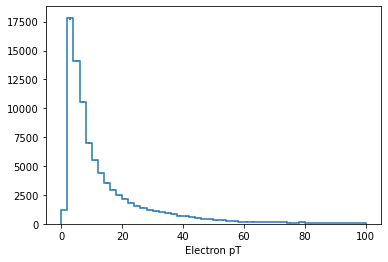

In [14]:
h = hist.Hist(hist.axis.Regular(50, 0, 100, name="Electron pT"))
h.fill(ak.flatten(ak_el_pt))
h.plot();

<br>
<br>
<br>
<br>

<font size="3">
    
FuncADL expression can be also replaced by ROOT TCut syntax (for scalar type branches):<br>

```
FuncADL: "Where(lambda event: event.nelectron_pt > 5). \
        Select(lambda event: {'electron_pt': event.electron_pt})"
```
    by

```
Filter: nelectron_pt > 5
Columns: electron_pt
```

In [20]:
%%writefile config_example_2.yml
General:
  ServiceXBackendName: uproot_uc_af
  OutputDirectory: ServiceXData_2
  OutputFormat: parquet

Sample:
  - Name: ttbar
    Tree: events
    Filter: nelectron_pt > 6
    Columns: electron_pt
    XRootDFiles: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/020D0AF1-4BC2-E511-BDFC-0026B95ADB18.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/02837459-03C2-E511-8EA2-002590A887AC.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0400D1B1-4CC2-E511-AD14-AC853DA06A1A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0634456A-08C2-E511-A0C1-001E6739722E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5A5364-03C2-E511-9352-00259048AE00.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5C7429-0CC2-E511-BC6B-002590D9D8B8.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0AE230FC-4BC2-E511-B35C-000F530E4644.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0C5BB11A-E2C1-E511-8C02-002590A831B6.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/10D0AF2E-33C2-E511-BCE5-001E67398683.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/14C8A87C-DCC1-E511-BE67-0CC47A0AD704.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/14F4047E-0CC2-E511-B1CE-002590A3C970.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/16467C82-D8C1-E511-9546-001E67E71417.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/167A53AB-08C2-E511-A58B-001E67397F2B.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/18897870-17C2-E511-9DC5-E41D2D08DCA0.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/18CCDFE4-02C2-E511-B0FA-002590A37114.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/20A0646D-D8C1-E511-9587-001E67396A09.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2235F83F-DBC1-E511-A83F-001E673986B5.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/22761DF1-E1C1-E511-8F86-003048CB8584.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/244D8186-D8C1-E511-B684-001E67E71BF5.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/26CAB9BA-CEC1-E511-8B0B-001E67398E49.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2A18493A-04C2-E511-935C-002590D9D8C2.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2C7F8762-0CC2-E511-9F77-001E673981C4.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2CA9FB72-17C2-E511-A3E3-0025907DCA7E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2CCB8F4A-07C2-E511-A3C6-002590A3C970.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/2EF6150C-1AC2-E511-A67B-002590A83192.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/324D4BDC-DCC1-E511-925D-00259029E922.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/32D38D09-E2C1-E511-986A-001E67397BC5.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/32E942A0-4DC2-E511-AD4A-001E674FCBF7.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/343CDCDC-E1C1-E511-80C4-00259029E91C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/36171880-02C2-E511-9B6E-0CC47A0AD630.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/363584E8-4BC2-E511-9DE3-008CFAF060D8.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/3660CB69-35C2-E511-86B8-002590A83354.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/366A2A31-D8C1-E511-8A68-001E67396E32.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/3C73C475-08C2-E511-B273-001E67E71943.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/3E146760-D8C1-E511-A6E1-0CC47A57D136.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/401D0082-08C2-E511-9934-001E6739677A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/4207E269-0CC2-E511-BB42-001E6739801B.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/42110E2D-13C2-E511-9460-0025B3E064F8.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/46D80108-06C2-E511-B908-001E67E7136D.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/48B429A9-D2C1-E511-BED7-002590A80E1C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/4C675E0C-01C2-E511-B25E-002590D9D96E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/4EF74313-E2C1-E511-88F6-001E67397396.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/503646F9-35C2-E511-8CF5-001E6739751C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/52CAF991-DBC1-E511-B168-00259048A860.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/547D8379-D8C1-E511-9EEA-00259048A8F0.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/563553BB-D5C1-E511-826F-001E67E6F89B.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/56535980-D8C1-E511-9C47-001E67E71DDA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/58126B26-D8C1-E511-8BDA-002481E14E48.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/5879C6E0-00C2-E511-958C-0CC47A0AD630.root

Overwriting config_example_2.yml


In [21]:
sx = DataBinder("config_example_2.yml")

INFO - Loading DataBinder config file: config_example_2.yml
INFO -   1 Samples and 1 ServiceX requests


In [22]:
%%time
out_2 = sx.deliver()

INFO - Deliver via ServiceX endpoint: https://uproot-atlas.servicex.af.uchicago.edu/


ttbar - events:   0%|                                                                                         …

        ttbar - events Downloaded:   0%|                                                                      …

INFO -   ttbar | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13 is already delivered
INFO - Wrote a yaml file containing delivered file paths: /Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_2/out_example_2.yml


<font size="3">

Since the same query on the same dataset is found at the local cache, the delivery request is not propagated to the ServiceX and data is pulled from the local cache. 

A change in the query and/or name of dataset will initiate new ServiceX data delivery.

<br>
<br>
<br>
<br>

<font size="3">

It's more practical to use experimental data behind an auth, thus `RucioDID` will be typical  type of dataset (supported by ServiceX).

Let's run on a rucio dataset, which amounts to 11 GB (114 files) at BNL and Munich ATLAS storage (Only ATLAS member can get an access token for ATLAS ServiceX endpoints).

In [5]:
%%writefile config_example_3.yml
General:
  ServiceXBackendName: uproot_uc_af
  OutputDirectory: ServiceXData_3
  OutputFormat: parquet

Sample:
  - Name: singleTop
    RucioDID: user.ivukotic:user.ivukotic.single_top_s_chan__nominal
    Tree: events    
    Filter: nelectron_pt > 5
    Columns: electron_pt

Overwriting config_example_3.yml


In [6]:
%%time
out_3 = DataBinder("config_example_3.yml").deliver()

INFO - Loading DataBinder config file: config_example_3.yml
INFO -   1 Samples and 1 ServiceX requests
INFO - Deliver via ServiceX endpoint: https://uproot-atlas.servicex.af.uchicago.edu/
INFO -   singleTop | events | user.ivukotic:user.ivukotic.single_top_s_chan__nominal is already delivered


CPU times: user 60.4 ms, sys: 9.41 ms, total: 69.8 ms
Wall time: 75.4 ms


<br>
<br>
<br>
<br>
<font size="3">
If you to avoid writing a file you can pass a config as dictionary.

In [7]:
config_4 = {
    "General":
    {
        "ServiceXBackendName": "uproot_uc_af",
        "OutputDirectory": "ServiceXData_3",
        "OutputFormat": "parquet"
    },
    "Sample":
    [
        {
            "Name": "singleTop",
            "RucioDID": "user.ivukotic:user.ivukotic.single_top_s_chan__nominal",
            "Tree": "events",
            "Filter": "nelectron_pt > 5",
            "Columns": "electron_pt"
        }
    ]
}

In [8]:
out_4 = DataBinder(config_4).deliver()

INFO -   1 Samples and 1 ServiceX requests
INFO - Deliver via ServiceX endpoint: https://uproot-atlas.servicex.af.uchicago.edu/
INFO -   singleTop | events | user.ivukotic:user.ivukotic.single_top_s_chan__nominal is already delivered


<br>
<br>
<br>
<br>

<font size="4">
    
<b><span style="color:blue"> Use-case 2. </span></b> 
An analyzer wants to exploit ServiceX for physics analysis

<font size="3">
<!-- <b>The development of ServiceX DataBinder puts the emphasis on UX (User experience), especially with full-
scale physics analysis.</b> -->

Full-scale analysis with ServiceX demands many more than delivering a single column. Thus, the emphasis of the DataBinder development is UX (User eXperience), especially with full-scale physics analysis.
    
- Multiple samples (or processes)
- Option `WriteOutputDict` in `General` block - write a yaml file containing paths of delivered files (an input for subsequent step such as coffea)
- `Definition` block - replace lengthy values for better readability

<font size="3">
    
The following configuration file contains three samples (`data`, `ttbar`, `wjets`) with the same query.

In [14]:
%%writefile config_example_5.yml
General:
  ServiceXBackendName: uproot_uc_af
  OutputDirectory: ServiceXData_5
  OutputFormat: parquet
  WriteOutputDict: out_example_5
  IgnoreServiceXCache: True

Sample:
  - Name: ttbar
    XRootDFiles: DEF_ttbar_inputs
    Tree: events    
    FuncADL: DEF_funcald
  - Name: wjets
    XRootDFiles: DEF_wjets_inputs
    Tree: events
    FuncADL: DEF_funcald
  - Name: data
    XRootDFiles: DEF_data_inputs
    Tree: events
    FuncADL: DEF_funcald

Definition:
    DEF_funcald: "Where(lambda event: event.nelectron_pt > 5). \
            Select(lambda event: {'electron_pt': event.electron_pt})"

    DEF_ttbar_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/020D0AF1-4BC2-E511-BDFC-0026B95ADB18.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/02837459-03C2-E511-8EA2-002590A887AC.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0400D1B1-4CC2-E511-AD14-AC853DA06A1A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0634456A-08C2-E511-A0C1-001E6739722E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5A5364-03C2-E511-9352-00259048AE00.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5C7429-0CC2-E511-BC6B-002590D9D8B8.root

    DEF_wjets_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/002B75B9-10DB-E511-915B-02163E017888.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/006E9C0C-12DB-E511-981C-00261894397D.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0097C77B-12DB-E511-AAC0-02163E011796.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00B697CF-10DB-E511-A9D9-782BCB407CFD.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00BC9D60-0FDB-E511-A038-00215AD4D670.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00D29FE6-0CDB-E511-8602-BCAEC53F6D4E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00F4DF03-10DB-E511-B5D3-842B2B185C54.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0228909F-10DB-E511-830F-002481E0DA4E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/027FF218-10DB-E511-8FAC-02163E013669.root
    
    DEF_data_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00006301-CAA8-E511-AD39-549F35AD8BC9.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/0034202D-A3A8-E511-BA9C-00259073E3DA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/0043758E-ECA8-E511-B849-002618FDA287.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/004C08BC-C8A8-E511-943C-00266CFAE6E0.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/005416D9-E0A8-E511-8AA1-0CC47A4C8E46.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00649463-BEA8-E511-9266-0CC47A4D769C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00AB7295-C6A8-E511-AEAF-0CC47A4C8E8A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00E42A7E-BAA8-E511-B23B-0CC47A4C8E86.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00F3E56E-BEA8-E511-A6A2-3417EBE722FA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/02004059-D9A8-E511-8790-0CC47A78A440.root

Overwriting config_example_5.yml


In [15]:
sx5 = DataBinder("config_example_5.yml")

INFO - Loading DataBinder config file: config_example_5.yml
INFO -   3 Samples and 3 ServiceX requests


<font size="3">

Showing the number of samples and corresponding number of ServiceX requests

In [16]:
%%time
out_5 = sx5.deliver()

INFO - Deliver via ServiceX endpoint: https://uproot-atlas.servicex.af.uchicago.edu/


data - events:   0%|                                                                                          …

        data - events Downloaded:   0%|                                                                       …

wjets - events:   0%|                                                                                         …

        wjets - events Downloaded:   0%|                                                                      …

ttbar - events:   0%|                                                                                         …

        ttbar - events Downloaded:   0%|                                                                      …

INFO -   wjets | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUE is already delivered
INFO -   ttbar | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13 is already delivered
INFO -   data | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v is already delivered
INFO - Wrote a yaml file containing delivered file paths: /Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_5/out_example_5.yml


CPU times: user 606 ms, sys: 98.2 ms, total: 704 ms
Wall time: 24.9 s


<font size="3">

All delivery requests are running simultaneously and copy outputs from each ServiceX request asynchronously (no more separate post-processing step).

<br>
<br>
<br>
<br>    

<font size="3">

If we change the selection or query or input on `ttbar` sample,

In [17]:
%%writefile config_example_6.yml
General:
  ServiceXBackendName: uproot_uc_af
  OutputDirectory: ServiceXData_6
  OutputFormat: parquet
  WriteOutputDict: out_example_6

Sample:
  - Name: ttbar
    XRootDFiles: DEF_ttbar_inputs
    Tree: events    
    FuncADL: "Where(lambda event: event.nelectron_pt > 5). \
            Select(lambda event: {'electron_pt': event.electron_pt, 'electron_eta': event.electron_eta})"
  - Name: wjets
    XRootDFiles: DEF_wjets_inputs
    Tree: events
    FuncADL: DEF_funcald
  - Name: data
    XRootDFiles: DEF_data_inputs
    Tree: events
    FuncADL: DEF_funcald

Definition:
    DEF_funcald: "Where(lambda event: event.nelectron_pt > 5). \
            Select(lambda event: {'electron_pt': event.electron_pt})"

    DEF_ttbar_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/020D0AF1-4BC2-E511-BDFC-0026B95ADB18.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/02837459-03C2-E511-8EA2-002590A887AC.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0400D1B1-4CC2-E511-AD14-AC853DA06A1A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0634456A-08C2-E511-A0C1-001E6739722E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5A5364-03C2-E511-9352-00259048AE00.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5C7429-0CC2-E511-BC6B-002590D9D8B8.root

    DEF_wjets_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/002B75B9-10DB-E511-915B-02163E017888.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/006E9C0C-12DB-E511-981C-00261894397D.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0097C77B-12DB-E511-AAC0-02163E011796.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00B697CF-10DB-E511-A9D9-782BCB407CFD.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00BC9D60-0FDB-E511-A038-00215AD4D670.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00D29FE6-0CDB-E511-8602-BCAEC53F6D4E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00F4DF03-10DB-E511-B5D3-842B2B185C54.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0228909F-10DB-E511-830F-002481E0DA4E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/027FF218-10DB-E511-8FAC-02163E013669.root
    
    DEF_data_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00006301-CAA8-E511-AD39-549F35AD8BC9.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/0034202D-A3A8-E511-BA9C-00259073E3DA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/0043758E-ECA8-E511-B849-002618FDA287.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/004C08BC-C8A8-E511-943C-00266CFAE6E0.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/005416D9-E0A8-E511-8AA1-0CC47A4C8E46.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00649463-BEA8-E511-9266-0CC47A4D769C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00AB7295-C6A8-E511-AEAF-0CC47A4C8E8A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00E42A7E-BAA8-E511-B23B-0CC47A4C8E86.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00F3E56E-BEA8-E511-A6A2-3417EBE722FA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/02004059-D9A8-E511-8790-0CC47A78A440.root

Writing config_example_6.yml


In [18]:
sx6 = DataBinder("config_example_6.yml")

INFO - Loading DataBinder config file: config_example_6.yml
INFO -   3 Samples and 3 ServiceX requests


In [19]:
%%time
out_6 = sx6.deliver()

INFO - Deliver via ServiceX endpoint: https://uproot-atlas.servicex.af.uchicago.edu/
INFO -   data | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v  is delivered
INFO -   wjets | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUE  is delivered


ttbar - events:   0%|                                                                                         …

        ttbar - events Downloaded:   0%|                                                                      …

INFO -   ttbar | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13  is delivered
INFO - Wrote a yaml file containing delivered file paths: /Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_6/out_example_6.yml


CPU times: user 245 ms, sys: 44.8 ms, total: 290 ms
Wall time: 26.9 s


<font size="3">

Runs only for the updated request.

<br>
<br>
<br>
<br>    

<font size="3">

We all make mistakes..

In [20]:
%%writefile config_example_7.yml
General:
  ServiceXBackendName: uproot_uc_af
  OutputDirectory: ServiceXData_7
  OutputFormat: parquet
  WriteOutputDict: out_example_7

Sample:
  - Name: ttbar
    XRootDFiles: DEF_ttbar_inputs
    Tree: events
    FuncADL: "Where(lambda event: event.nelectron_pt > 5). \
            Select(lambda event: {'electron_pt': event.electron_pt, 'electron_eta': event.electron_eto})"
  - Name: wjets
    XRootDFiles: DEF_wjets_inputs
    Tree: events
    FuncADL: DEF_funcald
  - Name: data
    XRootDFiles: DEF_data_inputs
    Tree: events
    FuncADL: DEF_funcald

Definition:
    DEF_funcald: "Where(lambda event: event.nelectron_pt > 5). \
            Select(lambda event: {'electron_pt': event.electron_pt})"

    DEF_ttbar_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/020D0AF1-4BC2-E511-BDFC-0026B95ADB18.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/02837459-03C2-E511-8EA2-002590A887AC.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0400D1B1-4CC2-E511-AD14-AC853DA06A1A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0634456A-08C2-E511-A0C1-001E6739722E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5A5364-03C2-E511-9352-00259048AE00.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5C7429-0CC2-E511-BC6B-002590D9D8B8.root

    DEF_wjets_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/002B75B9-10DB-E511-915B-02163E017888.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/006E9C0C-12DB-E511-981C-00261894397D.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0097C77B-12DB-E511-AAC0-02163E011796.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00B697CF-10DB-E511-A9D9-782BCB407CFD.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00BC9D60-0FDB-E511-A038-00215AD4D670.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00D29FE6-0CDB-E511-8602-BCAEC53F6D4E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00F4DF03-10DB-E511-B5D3-842B2B185C54.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0228909F-10DB-E511-830F-002481E0DA4E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/027FF218-10DB-E511-8FAC-02163E013669.root
    
    DEF_data_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00006301-CAA8-E511-AD39-549F35AD8BC9.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/0034202D-A3A8-E511-BA9C-00259073E3DA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/0043758E-ECA8-E511-B849-002618FDA287.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/004C08BC-C8A8-E511-943C-00266CFAE6E0.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/005416D9-E0A8-E511-8AA1-0CC47A4C8E46.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00649463-BEA8-E511-9266-0CC47A4D769C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00AB7295-C6A8-E511-AEAF-0CC47A4C8E8A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00E42A7E-BAA8-E511-B23B-0CC47A4C8E86.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00F3E56E-BEA8-E511-A6A2-3417EBE722FA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/02004059-D9A8-E511-8790-0CC47A78A440.root

Writing config_example_7.yml


In [21]:
sx7 = DataBinder("config_example_7.yml")

INFO - Loading DataBinder config file: config_example_7.yml
INFO -   3 Samples and 3 ServiceX requests


In [22]:
%%time
out_7 = sx7.deliver()

INFO - Deliver via ServiceX endpoint: https://uproot-atlas.servicex.af.uchicago.edu/
INFO -   data | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v  is delivered
INFO -   wjets | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUE  is delivered


ttbar - event:   0%|                                                                                          …

        ttbar - event Downloaded:   0%|                                                                       …

WARNING - Transform bbc8c1cf-049a-4156-8c91-c2c16581a4e7 had 0 errors:
INFO -   Fail to deliver ttbar | event | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13
INFO - Wrote a yaml file containing delivered file paths: /Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_7/out_example_7.yml
WARNING - 1 failed delivery request(s)
WARNING - get_failed_requests() for detail of failed requests


<font size="3">
    
Oops.. something went wrong. I have 1 failed request. Let's have a look.

In [40]:
failed = sx7.get_failed_requests()
print(f"Failed request:\n {failed[0]['request']}\n")
print(f"Error message:\n {failed[0]['error']}")

Failed request:
 {'Sample': 'ttbar', 'dataset': ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root', 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/020D0AF1-4BC2-E511-BDFC-0026B95ADB18.root', 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/02837459-03C2-E511-8EA2-002590A887AC.root', 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0400D1B1-4CC2-E511-AD14-AC853DA06A1A.root', 'https://xrootd-local.unl.e

<br>
<br>
<br>
<br>
<font size="3">

Six progress bars look great! but a typical analysis accesses many more datasets (>100). Added an option for the people who don't like flashing screen.

In [25]:
sx8 = DataBinder('config_example_5.yml')

INFO - Loading DataBinder config file: config_example_5.yml
INFO -   3 Samples and 3 ServiceX requests


In [26]:
%%time
out_8 = sx8.deliver(overall_progress_only=True)

INFO - Deliver via ServiceX endpoint: https://uproot-atlas.servicex.af.uchicago.edu/
  data | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v is already delivered: 100%|████████| 3/3 [00:22]
INFO - Wrote a yaml file containing delivered file paths: /Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_5/out_example_5.yml


<br>
<br>
<br>
<br>
<font size="3">

Set output format as ROOT delivers ROOT ntuples instead of parquets.

    General:
      OutputFormat: root

In [28]:
%%writefile config_example_8.yml
General:
  ServiceXBackendName: uproot_uc_af
  OutputDirectory: ServiceXData_8
  OutputFormat: root
  WriteOutputDict: out_example_8

Sample:
  - Name: ttbar
    XRootDFiles: DEF_ttbar_inputs
    Tree: events    
    FuncADL: DEF_funcald
  - Name: wjets
    XRootDFiles: DEF_wjets_inputs
    Tree: events
    FuncADL: DEF_funcald
  - Name: data
    XRootDFiles: DEF_data_inputs
    Tree: events
    FuncADL: DEF_funcald

Definition:
    DEF_funcald: "Where(lambda event: event.nelectron_pt > 5). \
            Select(lambda event: {'electron_pt': event.electron_pt})"

    DEF_ttbar_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/020D0AF1-4BC2-E511-BDFC-0026B95ADB18.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/02837459-03C2-E511-8EA2-002590A887AC.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0400D1B1-4CC2-E511-AD14-AC853DA06A1A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0634456A-08C2-E511-A0C1-001E6739722E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5A5364-03C2-E511-9352-00259048AE00.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5C7429-0CC2-E511-BC6B-002590D9D8B8.root

    DEF_wjets_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/002B75B9-10DB-E511-915B-02163E017888.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/006E9C0C-12DB-E511-981C-00261894397D.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0097C77B-12DB-E511-AAC0-02163E011796.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00B697CF-10DB-E511-A9D9-782BCB407CFD.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00BC9D60-0FDB-E511-A038-00215AD4D670.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00D29FE6-0CDB-E511-8602-BCAEC53F6D4E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00F4DF03-10DB-E511-B5D3-842B2B185C54.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0228909F-10DB-E511-830F-002481E0DA4E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/027FF218-10DB-E511-8FAC-02163E013669.root
    
    DEF_data_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00006301-CAA8-E511-AD39-549F35AD8BC9.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/0034202D-A3A8-E511-BA9C-00259073E3DA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/0043758E-ECA8-E511-B849-002618FDA287.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/004C08BC-C8A8-E511-943C-00266CFAE6E0.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/005416D9-E0A8-E511-8AA1-0CC47A4C8E46.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00649463-BEA8-E511-9266-0CC47A4D769C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00AB7295-C6A8-E511-AEAF-0CC47A4C8E8A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00E42A7E-BAA8-E511-B23B-0CC47A4C8E86.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00F3E56E-BEA8-E511-A6A2-3417EBE722FA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/02004059-D9A8-E511-8790-0CC47A78A440.root

Writing config_example_8.yml


In [29]:
%%time
out_8 = DataBinder("config_example_8.yml").deliver()

INFO - Loading DataBinder config file: config_example_8.yml
INFO -   3 Samples and 3 ServiceX requests
INFO - Deliver via ServiceX endpoint: https://uproot-atlas.servicex.af.uchicago.edu/
INFO -   data | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v  is delivered
INFO -   ttbar | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13  is delivered
INFO -   wjets | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUE  is delivered
INFO - Wrote a yaml file containing delivered file paths: /Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_8/out_example_8.yml


<font size="3">
    
The returned file list has keys for all samples:

In [30]:
out_8.keys()

dict_keys(['ttbar', 'wjets', 'data'])

<font size="3">

Let's have a look a ROOT file from `ttbar` sample using `uproot`:

In [31]:
import uproot

In [36]:
with uproot.open(out_8['ttbar']['events'][0]) as root_file:
    print(root_file.keys())
    tree = root_file['events']

['events;1']


In [37]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nelectron_pt         | int32_t                  | AsDtype('>i4')
electron_pt          | float[]                  | AsJagged(AsDtype('>f4'))


<br>
<br>
<br>
<br>
<font size="3">

Input source of each Sample is not limited by a single type as long as an output format is the same. The following example config includes `ttbar` sample via `XRootDFiles`, `wjets` sample from `LocalPath`, and `singleTop` sample via `RucioDID`.

In [41]:
%%writefile config_example_9.yml
General:
  ServiceXBackendName: uproot_uc_af
  OutputDirectory: ServiceXData_9
  OutputFormat: root
  WriteOutputDict: out_example_9

Sample:
  - Name: ttbar
    XRootDFiles: DEF_ttbar_inputs
    Tree: events    
    FuncADL: DEF_funcald
  - Name: wjets
    LocalPath: /Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_8/wjets/events
    Tree: events
  - Name: data
    XRootDFiles: DEF_data_inputs
    Tree: events
    FuncADL: DEF_funcald
  - Name: singleTop
    RucioDID: user.ivukotic:user.ivukotic.single_top_s_chan__nominal
    Tree: events    
    Filter: nelectron_pt > 5
    Columns: electron_pt

Definition:
    DEF_funcald: "Where(lambda event: event.nelectron_pt > 5). \
            Select(lambda event: {'electron_pt': event.electron_pt})"

    DEF_ttbar_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/020D0AF1-4BC2-E511-BDFC-0026B95ADB18.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/02837459-03C2-E511-8EA2-002590A887AC.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0400D1B1-4CC2-E511-AD14-AC853DA06A1A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0634456A-08C2-E511-A0C1-001E6739722E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5A5364-03C2-E511-9352-00259048AE00.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/0A5C7429-0CC2-E511-BC6B-002590D9D8B8.root

    DEF_wjets_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/002B75B9-10DB-E511-915B-02163E017888.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/006E9C0C-12DB-E511-981C-00261894397D.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0097C77B-12DB-E511-AAC0-02163E011796.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00B697CF-10DB-E511-A9D9-782BCB407CFD.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00BC9D60-0FDB-E511-A038-00215AD4D670.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00D29FE6-0CDB-E511-8602-BCAEC53F6D4E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/00F4DF03-10DB-E511-B5D3-842B2B185C54.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/0228909F-10DB-E511-830F-002481E0DA4E.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1/10000/027FF218-10DB-E511-8FAC-02163E013669.root
    
    DEF_data_inputs: https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00006301-CAA8-E511-AD39-549F35AD8BC9.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/0034202D-A3A8-E511-BA9C-00259073E3DA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/0043758E-ECA8-E511-B849-002618FDA287.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/004C08BC-C8A8-E511-943C-00266CFAE6E0.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/005416D9-E0A8-E511-8AA1-0CC47A4C8E46.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00649463-BEA8-E511-9266-0CC47A4D769C.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00AB7295-C6A8-E511-AEAF-0CC47A4C8E8A.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00E42A7E-BAA8-E511-B23B-0CC47A4C8E86.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/00F3E56E-BEA8-E511-A6A2-3417EBE722FA.root,
                https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v1/10000/02004059-D9A8-E511-8790-0CC47A78A440.root

Writing config_example_9.yml


In [42]:
%%time
out_9 = DataBinder("config_example_9.yml").deliver()

INFO - Loading DataBinder config file: config_example_9.yml
INFO -   4 Samples and 3 ServiceX requests
INFO - Deliver via ServiceX endpoint: https://uproot-atlas.servicex.af.uchicago.edu/
INFO -   data | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/Run2015D/SingleMuon/MINIAOD/16Dec2015-v  is delivered
INFO -   ttbar | events | ['https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13  is delivered
INFO -   singleTop | events | user.ivukotic:user.ivukotic.single_top_s_chan__nominal  is delivered
INFO -   wjets | events | /Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_8/wjets/events is from local path
INFO - Wrote a yaml file containing delivered file paths: /Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_9/out_example_9.yml


CPU times: user 817 ms, sys: 88.5 ms, total: 906 ms
Wall time: 936 ms


In [43]:
out_9.keys()

dict_keys(['ttbar', 'wjets', 'data', 'singleTop'])

In [47]:
out_9['wjets']['events']

['/Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_8/wjets/events/f27a1b79c94d8bc55558bf208f3e8101-oFXFX-pythia8_MINIAODSIM_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1_10000_00BC9D60-0FDB-E511-A038-00215AD4D670.root.root',
 '/Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_8/wjets/events/98f6008af3339bd8cbb771798e72fe27-oFXFX-pythia8_MINIAODSIM_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1_10000_00F4DF03-10DB-E511-B5D3-842B2B185C54.root.root',
 '/Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_8/wjets/events/24aea045196706cdf08cb7e42452bdb8-oFXFX-pythia8_MINIAODSIM_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1_10000_00B697CF-10DB-E511-A9D9-782BCB407CFD.root.root',
 '/Users/kchoi/Work/UTAustin/Computing/ServiceX/presentations/16Nov2022_irishep_topicalMeeting/ServiceXData_8/wjets/events/e41cf577ec641e4c

<br>
<br>
<br>
<br>
<font size="3">
    
Back to the subject
    <b>"An analyzer wants to exploit ServiceX for physics analysis"</b>

There are diverse ways to get results from large datasets on data centers. Every analysis has own problems and even various needs within an analysis team. The following schematic shows three example analysis workflows with ServiceX:
- <span style="color:blue">Delivery of ROOT ntuple (dashed)</span>: minimal change with respect to the traditional workflow. An analyzer gets selected and filtered branches in ROOT format via ServiceX, and performs subsequent analyses with familiar tools.
<br>

- <span style="color:blue">ServiceX + Coffea (thick)</span>: more toward Python ecosystem. ServiceX delivers Apache parquet files containing awkward arrays, and a core analysis is done using coffea framework.
<br>

- <span style="color:blue">ServiceX + Coffea + Cabinetry (pyhf) (thick + thin)</span>: analysis fully in Python ecosystem, a.k.a. Analysis Grand Challenge


<br>

<img src="img/workflows" width=900 />

    
<br>
<br>

<br>
<br>
<br>
<br>

<font size="3">

The returned file list by ServiceX DataBinder is then passed to coffea framework for a main analysis.

Whenever you need new columns or samples, you can modify the configuration file and new ServiceX data delivery requests are submitted only for updated samples. This allows you to maintain your data conveniently.

The following code snippet is an example from my coffea analysis code:

    from coffea.nanoevents import NanoAODSchema
    from coffea import processor

    run = processor.Runner(processor.FuturesExecutor(workers=30, merging=True),
                       format="parquet", schema=NanoAODSchema)
    output = run(fileset, "Events", fcnc_2lSS())

<br>
<br>
<br>
<br>

Github repo: https://github.com/kyungeonchoi/ServiceXDataBinder